In [1]:
from PIL import Image

# Open an image file
img = Image.open('fox.jpg')

# Define the new size
ratio = 5
new_width = int(img.size[0]//ratio)
new_height = int(img.size[1]//ratio)

# Resize the image
resized_img = img.resize((new_width, new_height))

# Save the resized image
resized_img.save('resized_fox.jpg')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.io as skio
import torch.optim as optim
import skimage as sk

In [3]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(np.sin(1*2**0*3.14159))

2.65358979335273e-06


In [158]:
ppp = torch.tensor([[0.35,0.24],[0.1,0.2]])
# ppp = torch.tensor([[0.35,0.24]])
d_model = 5
pe =  torch.zeros(len(ppp), d_model*4)
div_term = torch.exp2(torch.arange(0, d_model)).float()*3.14159
for i in range(len(ppp)):
    pe[i, 0:d_model*2:2] = torch.sin(ppp[i,0] * div_term)
    pe[i, 1:d_model*2+1:2] = torch.cos(ppp[i,0] * div_term)
    pe[i, d_model*2::2] = torch.sin(ppp[i,1] * div_term)
    pe[i, d_model*2+1::2] = torch.cos(ppp[i,1] * div_term)
# print(pe.shape)
# print(ppp.shape)
print(torch.cat((ppp,pe),dim=1))

tensor([[ 0.3500,  0.2400,  0.8910,  0.4540,  0.8090, -0.5878, -0.9511, -0.3090,
          0.5878, -0.8090, -0.9511,  0.3090,  0.6845,  0.7290,  0.9980,  0.0628,
          0.1253, -0.9921, -0.2487,  0.9686, -0.4818,  0.8763],
        [ 0.1000,  0.2000,  0.3090,  0.9511,  0.5878,  0.8090,  0.9511,  0.3090,
          0.5878, -0.8090, -0.9511,  0.3090,  0.5878,  0.8090,  0.9511,  0.3090,
          0.5878, -0.8090, -0.9511,  0.3090, -0.5878, -0.8090]])


In [105]:
class two_d_reconstruct_model(nn.Module):
    def __init__(self,high_fre_level ,hidden_layer_number, hidden_dim):
        super(two_d_reconstruct_model, self).__init__()
        self.high_fre_level = high_fre_level
        self.input_layer = nn.Linear(2+high_fre_level*4, hidden_dim)
        # self.input_layer = nn.Linear(2, hidden_dim)
        hidden_layer_list = []
        for i in range(hidden_layer_number):
            hidden_layer_list.append(nn.Linear(hidden_dim, hidden_dim))
            hidden_layer_list.append(nn.ReLU())
        self.hidden_layer = nn.Sequential(*hidden_layer_list)
        self.out = nn.Linear(hidden_dim, 3)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def positional_encoding(self, data, high_fre_level):
        d = data.shape[1]
        length = len(data)
        data = data.to(device)
        pe = torch.zeros(length, self.high_fre_level*2*d).to(device)
        div_term = torch.exp2(torch.arange(0, self.high_fre_level))*3.14159
        div_term = div_term.to(device)
        for i in range(len(data)):
            for j in range(d):
                pe[i, 2*j*self.high_fre_level:self.high_fre_level*(j+1)*2:2] = torch.sin(data[i,j] * div_term)
                pe[i, 1 + 2*j*self.high_fre_level:self.high_fre_level*(j+1)*2+1:2] = torch.cos(data[i,j] * div_term)
                # pe[i, 0:self.high_fre_level*2:2] = torch.sin(data[i,0] * div_term)
                # pe[i, 1:self.high_fre_level*2+1:2] = torch.cos(data[i,0] * div_term)
                # pe[i, self.high_fre_level*2::2] = torch.sin(data[i,1] * div_term)
                # pe[i, self.high_fre_level*2+1::2] = torch.cos(data[i,1] * div_term)
        return pe

    # def positional_encoding(self, data, high_fre_level):
    #     d = data.shape[1]
    #     length = len(data)
    #     data = data.to(device)
    #     pe = torch.zeros(length, self.high_fre_level*2*d).to(device)
    #     div_term = torch.exp2(torch.arange(0, self.high_fre_level))*3.14159
    #     div_term = div_term.to(device)
    #     # for i in range(len(data)):
    #     for j in range(d):
    #         pe[:, 2*j*self.high_fre_level:self.high_fre_level*(j+1)*2:2] = torch.sin(data[:,j] * div_term)
    #         pe[:, 1 + 2*j*self.high_fre_level:self.high_fre_level*(j+1)*2+1:2] = torch.cos(data[:,j] * div_term)
    #         # pe[i, 0:self.high_fre_level*2:2] = torch.sin(data[i,0] * div_term)
    #         # pe[i, 1:self.high_fre_level*2+1:2] = torch.cos(data[i,0] * div_term)
    #         # pe[i, self.high_fre_level*2::2] = torch.sin(data[i,1] * div_term)
    #         # pe[i, self.high_fre_level*2+1::2] = torch.cos(data[i,1] * div_term)
    #     return pe
    
    def forward(self,data):
        # length = len(data)
        # data = data.to(device)
        # pe = torch.zeros(length, self.high_fre_level*4).to(device)
        # div_term = torch.exp2(torch.arange(0, self.high_fre_level))*3.14159
        # div_term = div_term.to(device)
        # for i in range(len(data)):
        #     pe[i, 0:self.high_fre_level*2:2] = torch.sin(data[i,0] * div_term)
        #     pe[i, 1:self.high_fre_level*2+1:2] = torch.cos(data[i,0] * div_term)
        #     pe[i, self.high_fre_level*2::2] = torch.sin(data[i,1] * div_term)
        #     pe[i, self.high_fre_level*2+1::2] = torch.cos(data[i,1] * div_term)
        pe = self.positional_encoding(data, self.high_fre_level)
        x = torch.cat((data,pe),dim=1)
        # x = data
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hidden_layer(x)
        x = self.out(x)
        return self.sigmoid(x)

In [98]:
pic_name = "resized_fox.jpg"
im = skio.imread(pic_name)
im = sk.img_as_float(im)
print(im.shape)
height = im.shape[0]
width = im.shape[1]

(137, 204, 3)


In [99]:
class two_d_dataset(Dataset):
    def __init__(self, img_path):
        im = skio.imread(img_path)
        self.image = sk.img_as_float(im)
        self.height = self.image.shape[0]
        self.width = self.image.shape[1]
    def __len__(self):
        return self.height*self.width - 1
    
    def __getitem__(self, idx):
        x = idx // self.width 
        y = idx % self.width 
        rgb = [self.image[x,y,0],
               self.image[x,y,1],
               self.image[x,y,2]]
        sample = {'input':torch.tensor([x/self.height,y/ self.width]),
                  "label":torch.tensor(rgb)}
        return sample

In [100]:
fox_dataset = two_d_dataset(pic_name)

In [101]:
dataloader = DataLoader(fox_dataset, batch_size=10000,
                        shuffle=True)

In [102]:
model = two_d_reconstruct_model(10,3,256).to(device)

In [103]:
class PSNRWithMSELoss(nn.Module):
    def __init__(self):
        super(PSNRWithMSELoss, self).__init__()
        
    def forward(self, predicted, target):
        # mse_loss = nn.MSELoss()(predicted, target)
        # mse_loss = nn.MSELoss()(predicted, target)
        # psnr = 10 * torch.log10(1 / mse_loss)
        mse_loss = torch.mean((predicted - target) ** 2)
        psnr = 10 * torch.log10(1 / mse_loss)
        return psnr

In [104]:
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = PSNRWithMSELoss()
criterion = torch.nn.MSELoss()
epoch_once = height * width/ 10000
number_iteration  = 1000
num_epochs = int(number_iteration /epoch_once) + 1
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(dataloader):
        inputs = sample_batched['input'].float().to(device)
        labels = sample_batched['label'].float().to(device)
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i_batch) % 10000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
#     print(sample_batched['rgb'][0].shape)

RuntimeError: The size of tensor a (10000) must match the size of tensor b (10) at non-singleton dimension 0

In [80]:
model.eval()
result = np.zeros((im.shape[0],im.shape[1],3))
for i in range(im.shape[0]):
    points = [[i/height,j/width] for j in range(im.shape[1])]
    temp_tensor = torch.tensor(points).float().to(device)
    temp_result = model(temp_tensor)
    temp_array = temp_result.detach().cpu().numpy()
    result[i,:,:] = temp_array

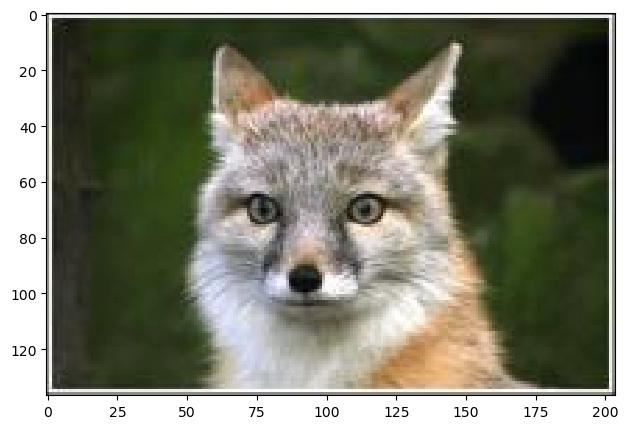

In [250]:
skio.imshow(im)

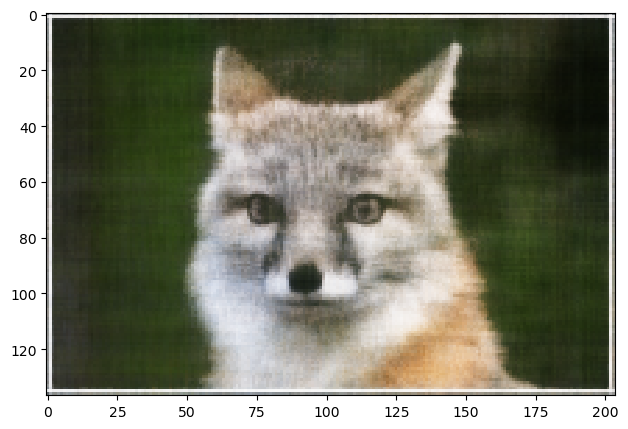

In [81]:
skio.imshow(result)